# Mid-Sem Assessment
Rakshith Vaishnavi Dogra

21218

DSE 627 

## Defining the TSP Environment

In [105]:
"""Environment for Modified Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple

import gymnasium as gym
import numpy as np
from numpy import typing as npt
import numpy as np
import matplotlib.pyplot as plt

class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


def main() -> None:
    """Main function."""
    num_targets = 10

    env = ModTSP(num_targets)
    obs = env.reset()
    ep_rets = []

    for ep in range(100):
        ret = 0
        obs = env.reset()
        for _ in range(100):
            action = env.action_space.sample()  # You need to replace this with your algorithm that predicts the action.

            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

        ep_rets.append(ret)
        print(f"Episode {ep} : {ret}")

    print(np.mean(ep_rets))


if __name__ == "__main__":
    main()

Episode 0 : -39899.527057647705
Episode 1 : -39917.79465389252
Episode 2 : -29817.927423000336
Episode 3 : -39838.94773197174
Episode 4 : -19891.989764213562
Episode 5 : -29966.920699119568
Episode 6 : -29928.623037338257
Episode 7 : -29886.826588630676
Episode 8 : -29931.006182670593
Episode 9 : -39794.316407203674
Episode 10 : -29857.589931488037
Episode 11 : -29860.5227394104
Episode 12 : -39763.68723869324
Episode 13 : -39802.06090736389
Episode 14 : -39899.67792510986
Episode 15 : -29782.353929519653
Episode 16 : -49927.317048072815
Episode 17 : -9980.583589553833
Episode 18 : -39816.80460143089
Episode 19 : -49818.269516944885
Episode 20 : -29911.478340148926
Episode 21 : -29967.64594745636
Episode 22 : -19719.006309509277
Episode 23 : -39785.58739042282
Episode 24 : -39833.27283287048
Episode 25 : -39842.8655166626
Episode 26 : -29880.894708633423
Episode 27 : -39975.080748558044
Episode 28 : -29897.978939533234
Episode 29 : -19943.208362579346
Episode 30 : -29782.43726873398
Ep

## Defining the SARSA Agent 

In [106]:
class SARSAAgent:
    def __init__(self, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state, next_action):
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_q - current_q)
        self.q_table[(state, action)] = new_q

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            q_values = [self.get_q_value(state, a) for a in range(self.action_size)]
            return np.argmax(q_values)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

## We simplify the state to only include the current location and visited targets
## Aim: To reduce the state space, to make the model learn faster

In [107]:
def simplify_state(state):
    # Extract only the current location and visited targets
    return (int(state[0]), tuple(state[1:11]))


In [108]:
def train_sarsa(env, episodes=5000, max_steps=100):
    action_size = env.action_space.n
    agent = SARSAAgent(action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.01)
    
    episode_rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = simplify_state(state)
        action = agent.get_action(state)
        total_reward = 0

        for _ in range(max_steps):
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = simplify_state(next_state)
            done = terminated or truncated

            next_action = agent.get_action(next_state)
            agent.update_q_value(state, action, reward, next_state, next_action)

            state = next_state
            action = next_action
            total_reward += reward

            if done:
                break

        agent.decay_epsilon()
        agent.learning_rate *= 0.995  # Decay learning rate
        episode_rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    return agent, episode_rewards

## Create and train the agent


Episode 100/5000, Total Reward: -39841.363149642944, Epsilon: 0.95
Episode 200/5000, Total Reward: -29869.31943845749, Epsilon: 0.90
Episode 300/5000, Total Reward: -39896.031185626984, Epsilon: 0.86
Episode 400/5000, Total Reward: -39799.33536672592, Epsilon: 0.82
Episode 500/5000, Total Reward: -29779.44909763336, Epsilon: 0.78
Episode 600/5000, Total Reward: -29846.487474918365, Epsilon: 0.74
Episode 700/5000, Total Reward: -39895.93286108971, Epsilon: 0.70
Episode 800/5000, Total Reward: -49838.06462478638, Epsilon: 0.67
Episode 900/5000, Total Reward: -39822.08860206604, Epsilon: 0.64
Episode 1000/5000, Total Reward: -39780.7089343071, Epsilon: 0.61
Episode 1100/5000, Total Reward: -49850.781047821045, Epsilon: 0.58
Episode 1200/5000, Total Reward: -39849.24295043945, Epsilon: 0.55
Episode 1300/5000, Total Reward: -39822.07422733307, Epsilon: 0.52
Episode 1400/5000, Total Reward: -19800.54625415802, Epsilon: 0.50
Episode 1500/5000, Total Reward: -29923.68510246277, Epsilon: 0.47
E

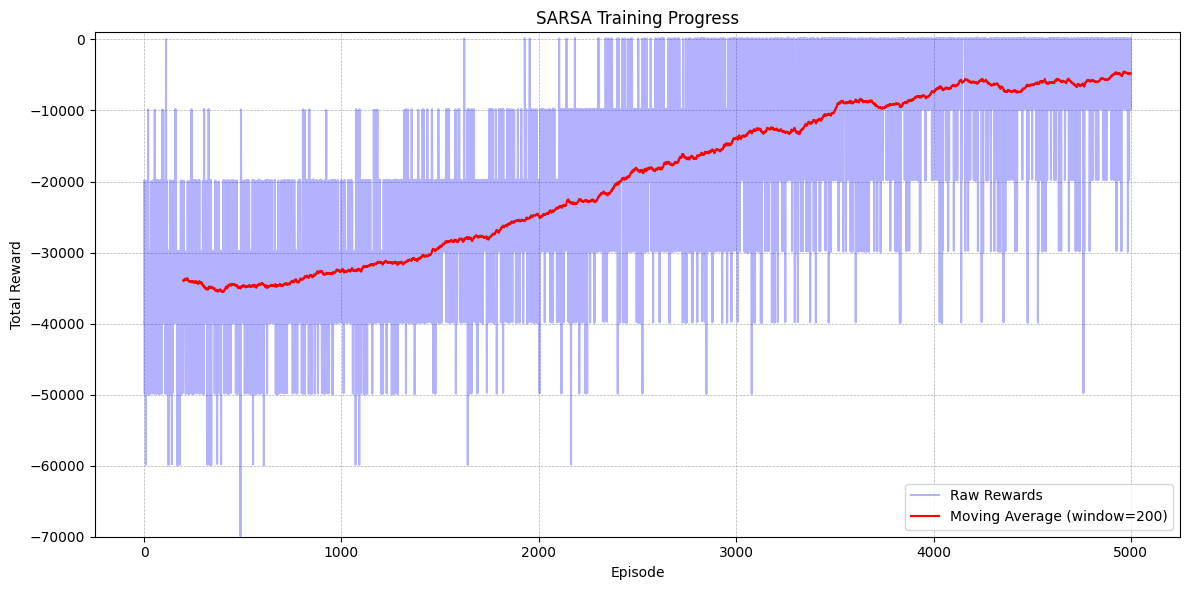

In [109]:
env = ModTSP()
trained_agent, episode_rewards = train_sarsa(env, episodes=5000)

# Plot the learning curve with both raw and smoothened rewards
plt.figure(figsize=(12, 6))

# Plot raw rewards
plt.plot(episode_rewards, alpha=0.3, color='blue', label='Raw Rewards')

# Calculate and plot moving average
window_size = 200
moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(episode_rewards)), moving_avg, color='red', label=f'Moving Average (window={window_size})')

plt.title('SARSA Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.ylim(-70000, 1000)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Evaluate the trained agent
state, _ = env.reset()
state = simplify_state(state)
total_reward = 0
done = False

while not done:
    action = trained_agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = simplify_state(next_state)
    done = terminated or truncated
    state = next_state
    total_reward += reward


## Training the Agent Without Reducting the State Space

In [110]:
import numpy as np
import matplotlib.pyplot as plt

class SARSAAgent:
    def __init__(self, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state, next_action):
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_q - current_q)
        self.q_table[(state, action)] = new_q

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            q_values = [self.get_q_value(state, a) for a in range(self.action_size)]
            return np.argmax(q_values)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def state_to_tuple(state):
    return tuple(state.astype(int))

def train_sarsa(env, episodes=5000, max_steps=100):
    action_size = env.action_space.n
    agent = SARSAAgent(action_size, learning_rate=0.01, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.01)
    
    episode_rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = state_to_tuple(state)
        action = agent.get_action(state)
        total_reward = 0

        for _ in range(max_steps):
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = state_to_tuple(next_state)
            done = terminated or truncated

            next_action = agent.get_action(next_state)
            agent.update_q_value(state, action, reward, next_state, next_action)

            state = next_state
            action = next_action
            total_reward += reward

            if done:
                break

        agent.decay_epsilon()
        agent.learning_rate *= 0.9995  # Decay learning rate
        episode_rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    return agent, episode_rewards

# Evaluation on the Full State Space with No. of Episodes as 5000

Episode 100/5000, Total Reward: -39841.363149642944, Epsilon: 0.95
Episode 200/5000, Total Reward: -29869.31943845749, Epsilon: 0.90
Episode 300/5000, Total Reward: -39896.031185626984, Epsilon: 0.86
Episode 400/5000, Total Reward: -39799.33536672592, Epsilon: 0.82
Episode 500/5000, Total Reward: -39785.81166934967, Epsilon: 0.78
Episode 600/5000, Total Reward: -29846.487474918365, Epsilon: 0.74
Episode 700/5000, Total Reward: -49930.79319477081, Epsilon: 0.70
Episode 800/5000, Total Reward: -59858.76550960541, Epsilon: 0.67
Episode 900/5000, Total Reward: -49818.567425727844, Epsilon: 0.64
Episode 1000/5000, Total Reward: -49810.979417324066, Epsilon: 0.61
Episode 1100/5000, Total Reward: -59855.873918533325, Epsilon: 0.58
Episode 1200/5000, Total Reward: -49809.41723060608, Epsilon: 0.55
Episode 1300/5000, Total Reward: -39822.07422733307, Epsilon: 0.52
Episode 1400/5000, Total Reward: -39819.83106136322, Epsilon: 0.50
Episode 1500/5000, Total Reward: -49967.395418167114, Epsilon: 0.

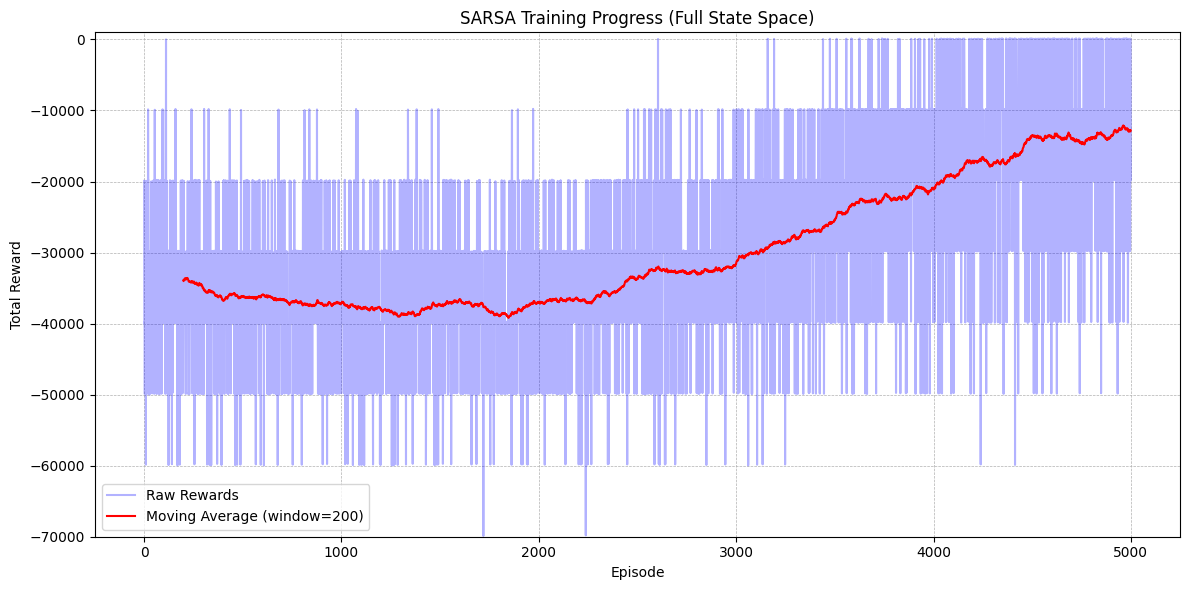

Evaluation - Total Reward: -19751.13835334778


In [111]:
# Create and train the agent
env = ModTSP()
trained_agent, episode_rewards = train_sarsa(env, episodes=5000)

# Plot the learning curve with both raw and smoothened rewards
plt.figure(figsize=(12, 6))

# Plot raw rewards
plt.plot(episode_rewards, alpha=0.3, color='blue', label='Raw Rewards')

# Calculate and plot moving average
window_size = 200
moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(episode_rewards)), moving_avg, color='red', label=f'Moving Average (window={window_size})')

plt.title('SARSA Training Progress (Full State Space)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.ylim(-70000, 1000)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Evaluate the trained agent
state, _ = env.reset()
state = state_to_tuple(state)
total_reward = 0
done = False

while not done:
    action = trained_agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = state_to_tuple(next_state)
    done = terminated or truncated
    state = next_state
    total_reward += reward

print(f"Evaluation - Total Reward: {total_reward}")

# Evaluation on the Full State Space with No. of Episodes as 10000

Episode 100/10000, Total Reward: -39841.363149642944, Epsilon: 0.95
Episode 200/10000, Total Reward: -29869.31943845749, Epsilon: 0.90
Episode 300/10000, Total Reward: -39896.031185626984, Epsilon: 0.86
Episode 400/10000, Total Reward: -39799.33536672592, Epsilon: 0.82
Episode 500/10000, Total Reward: -39785.81166934967, Epsilon: 0.78
Episode 600/10000, Total Reward: -29846.487474918365, Epsilon: 0.74
Episode 700/10000, Total Reward: -49930.79319477081, Epsilon: 0.70
Episode 800/10000, Total Reward: -59858.76550960541, Epsilon: 0.67
Episode 900/10000, Total Reward: -49818.567425727844, Epsilon: 0.64
Episode 1000/10000, Total Reward: -49810.979417324066, Epsilon: 0.61
Episode 1100/10000, Total Reward: -59855.873918533325, Epsilon: 0.58
Episode 1200/10000, Total Reward: -49809.41723060608, Epsilon: 0.55
Episode 1300/10000, Total Reward: -39822.07422733307, Epsilon: 0.52
Episode 1400/10000, Total Reward: -39819.83106136322, Epsilon: 0.50
Episode 1500/10000, Total Reward: -49967.3954181671

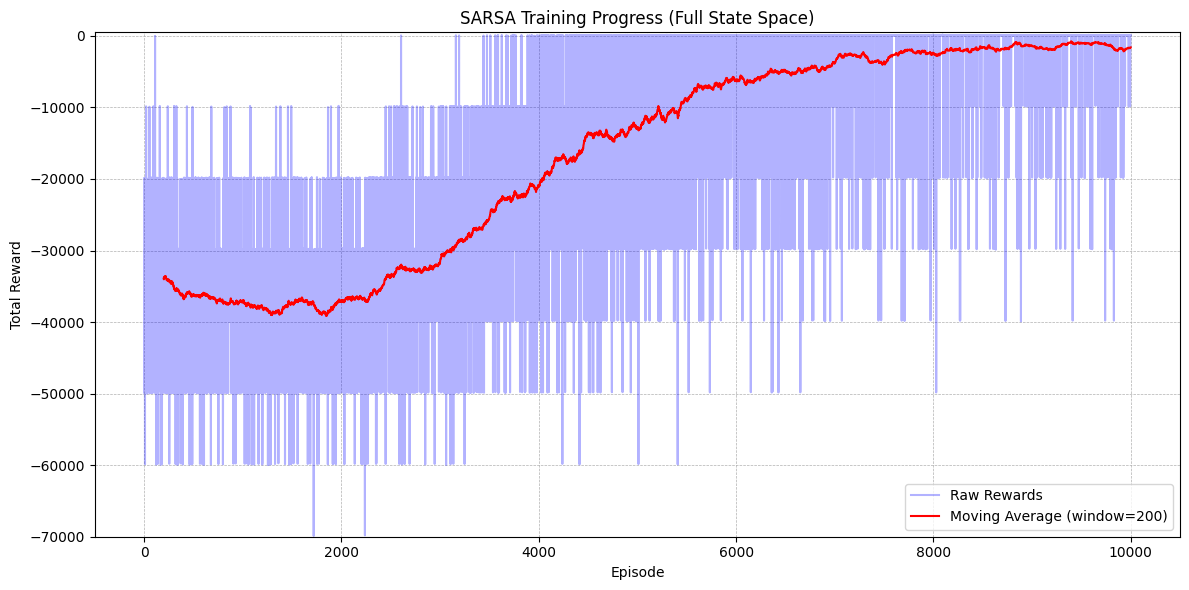

Evaluation - Total Reward: 91.22992324829102


In [112]:
env = ModTSP()
trained_agent, episode_rewards = train_sarsa(env, episodes=10000)

# Plot the learning curve with both raw and smoothened rewards
plt.figure(figsize=(12, 6))

# Plot raw rewards
plt.plot(episode_rewards, alpha=0.3, color='blue', label='Raw Rewards')

# Calculate and plot moving average
window_size = 200
moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(episode_rewards)), moving_avg, color='red', label=f'Moving Average (window={window_size})')

plt.title('SARSA Training Progress (Full State Space)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.ylim(-70000, 500)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Evaluate the trained agent
state, _ = env.reset()
state = state_to_tuple(state)
total_reward = 0
done = False

while not done:
    action = trained_agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = state_to_tuple(next_state)
    done = terminated or truncated
    state = next_state
    total_reward += reward

print(f"Evaluation - Total Reward: {total_reward}")